### Pytorch WorkFlows
- Getting data ready
- Building a model
- Fitting the model to data (training)
- Making predictions and evaluating a model (inference)
- Saving and loading a model
- Putting it all together

In [3]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.5.1+cu121'

#### Simple linear regression model

In [28]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [29]:
len(X), len(y)

(50, 50)

In [30]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [38]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test,
                     predictions=None):
    
    plt.figure(figsize=(10, 6))

    plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')
    plt.scatter(test_data, test_labels, c='g', s=4, label='Test data')

    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

    plt.legend(prop={"size": 14})

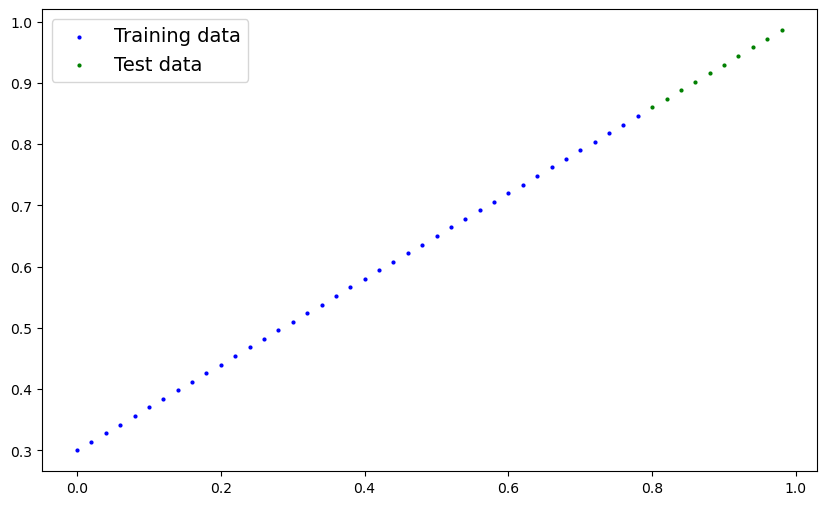

In [39]:
plot_predictions()

#### Build Model (Linear Regression)

In [40]:
# note : nn.Module is also an abstract class, so we need to overwrite the forward method

class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=float))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

In [41]:
torch.manual_seed(42)

model_0 = LinearRegression()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([0.1288], dtype=torch.float64, requires_grad=True)]

In [42]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367], dtype=torch.float64)),
             ('bias', tensor([0.1288], dtype=torch.float64))])

In [45]:
y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], dtype=torch.float64, grad_fn=<AddBackward0>)

In [46]:
# turn off gradient tracking <-- useful when we're making predictions instead of training. It reduces gradient tracking memory since we dont need them when we're only predicting.
with torch.inference_mode():
    y_preds = model_0(X_test)

# we can also do this <-- however inference mode is preffered
with torch.no_grad():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], dtype=torch.float64)

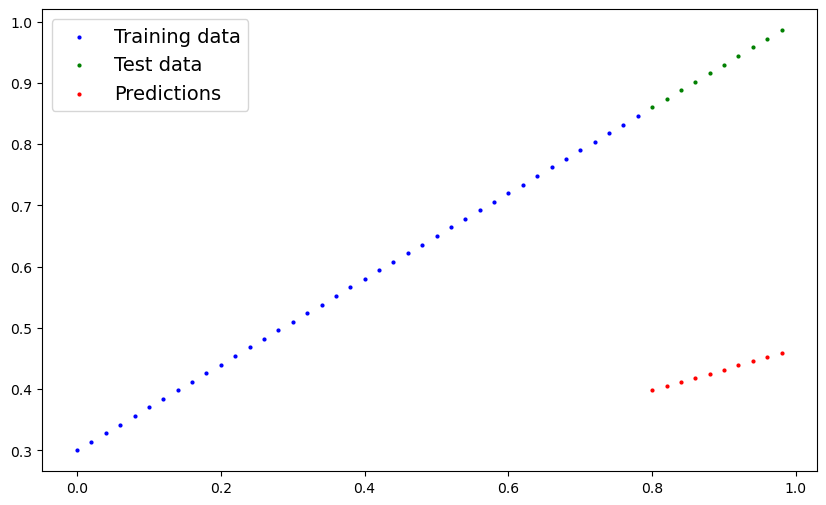

In [47]:
plot_predictions(predictions=y_preds)